In [1]:
import sys
sys.path.append('/e/dengnc')

import torch
import matplotlib.pyplot as plt
import numpy as np
from deeplightfield.my import util
from deeplightfield.msl_net import *

# Select device
torch.cuda.set_device(2)
print("Set CUDA:%d as current device." % torch.cuda.current_device())

Set CUDA:2 as current device.


# Test Ray-Sphere Intersection & Cartesian-Spherical Conversion

tensor([[ 1.4434,  1.4434, -1.4434]])
tensor(2.5000)
tensor([[[315.0000,  54.7356]]])


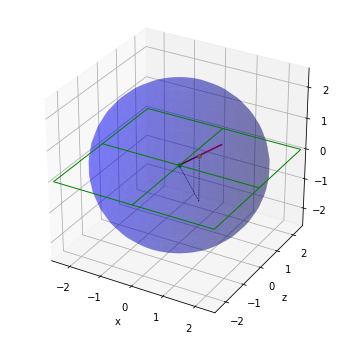

In [2]:
def PlotSphere(ax, r):
    u, v = np.mgrid[0:2 * np.pi:50j, 0:np.pi:20j]
    x = np.cos(u) * np.sin(v) * r
    y = np.sin(u) * np.sin(v) * r
    z = np.cos(v) * r
    ax.plot_surface(x, y, z, rstride=1, cstride=1,
                    color='b', linewidth=0.5, alpha=0.3)


def PlotPlane(ax, r):
    # 二元函数定义域平面
    x = np.linspace(-r, r, 3)
    y = np.linspace(-r, r, 3)
    X, Y = np.meshgrid(x, y)
    ax.plot_wireframe(X, Y, X * 0, color='g', linewidth=1)


p = torch.tensor([[0.0, 0.0, 0.0]])
v = torch.tensor([[1.0, 1.0, -1.0]])
r = torch.tensor([[2.5]])
v = v / torch.norm(v) * r * 2
p_on_sphere_ = RaySphereIntersect(p, v, r)[0]
print(p_on_sphere_)
print(p_on_sphere_.norm())
spher_coord = RayToSpherical(p, v, r)
print(spher_coord[..., 1:3].rad2deg())
p_on_sphere = SphericalToCartesian(spher_coord)[0]

fig = plt.figure(figsize=(6, 6))
ax = fig.gca(projection='3d')
plt.xlabel('x')
plt.ylabel('z')

PlotPlane(ax, r.item())
PlotSphere(ax, r[0, 0].item())

ax.scatter([0], [0], [0], color="g", s=10)  # Center
ax.scatter([p_on_sphere[0, 0].item()],
           [p_on_sphere[0, 2].item()],
           [p_on_sphere[0, 1].item()],
           color="r", s=10)  # Ray position
ax.scatter([p_on_sphere_[0, 0].item()],
           [p_on_sphere_[0, 2].item()],
           [p_on_sphere_[0, 1].item()],
           color="y", s=10)  # Ray position

p_ = p + v
ax.plot([p[0, 0].item(), p_[0, 0].item()],
        [p[0, 2].item(), p_[0, 2].item()],
        [p[0, 1].item(), p_[0, 1].item()],
        color="r")

ax.plot([p_on_sphere_[0, 0].item(), p_on_sphere_[0, 0].item()],
        [p_on_sphere_[0, 2].item(), p_on_sphere_[0, 2].item()],
        [0, p_on_sphere_[0, 1].item()], color="k", linestyle='--', linewidth=0.5)

ax.plot([p_on_sphere_[0, 0].item(), 0],
        [p_on_sphere_[0, 2].item(), 0],
        [0, 0],
        linewidth=0.5, linestyle="--", color="k")

ax.plot([p_on_sphere_[0, 0].item(), 0],
        [p_on_sphere_[0, 2].item(), 0],
        [p_on_sphere_[0, 1], 0],
        linewidth=0.5, linestyle="--", color="k")

ax.set_xlim(-r.item(), r.item())
ax.set_ylim(-r.item(), r.item())
ax.set_zlim(-r.item(), r.item())

plt.show()


# Test Dataset Loader & View-Spherical Transform

In [ ]:
from deeplightfield.data.spherical_view_syn import SphericalViewSynDataset

DATA_DIR = '../data/sp_view_syn_2020.12.26'
TRAIN_DATA_DESC_FILE = DATA_DIR + '/train.json'
DEPTH_RANGE = (1, 10)
N_DEPTH_LAYERS = 10

def _GetSphereLayers(depth_range: Tuple[float, float], n_layers: int) -> torch.Tensor:
    diopter_range = (1 / depth_range[1], 1 / depth_range[0])
    step = (diopter_range[1] - diopter_range[0]) / (n_layers - 1)
    depths = [1e5]
    depths += [1 / (diopter_range[0] + step * i) for i in range(n_layers)]
    return torch.tensor(depths, device=device.GetDevice()).view(-1, 1)

train_dataset = SphericalViewSynDataset(TRAIN_DATA_DESC_FILE)
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4,
    num_workers=8,
    pin_memory=True,
    shuffle=True,
    drop_last=False)
print(len(train_data_loader))

print("view_res", train_dataset.view_res)
print("cam_params", train_dataset.cam_params)

msl_net = MslNet(train_dataset.cam_params,
                 _GetSphereLayers(DEPTH_RANGE, N_DEPTH_LAYERS),
                 train_dataset.view_res).to(device.GetDevice())
print("sphere layers", msl_net.rendering.sphere_layers)

p = None
v = None
centers = None
plt.figure(figsize=(6, 6))
for _, view_images, ray_positions, ray_directions in train_data_loader:
    p = ray_positions
    v = ray_directions
    plt.subplot(2, 2, 1)
    util.PlotImageTensor(view_images[0])
    plt.subplot(2, 2, 2)
    util.PlotImageTensor(view_images[1])
    plt.subplot(2, 2, 3)
    util.PlotImageTensor(view_images[2])
    plt.subplot(2, 2, 4)
    util.PlotImageTensor(view_images[3])
    break
p_ = SphericalToCartesian(RayToSpherical(p.flatten(0, 1), v.flatten(0, 1),
                                         torch.tensor([[1]], device=device.GetDevice()))) \
    .view(4, train_dataset.view_res[0], train_dataset.view_res[1], 3)
v = v.view(4, train_dataset.view_res[0], train_dataset.view_res[1], 3)[:, 0::50, 0::50, :].flatten(1, 2).cpu().numpy()
p_ = p_[:, 0::50, 0::50, :].flatten(1, 2).cpu().numpy()

fig = plt.figure(figsize=(6, 6))
ax = fig.gca(projection='3d')
plt.xlabel('x')
plt.ylabel('z')

PlotSphere(ax, 1)

ax.scatter([0], [0], [0], color="k", s=10)  # Center

colors = [ 'r', 'g', 'b', 'y' ]
for i in range(4):
    ax.scatter(p_[i, :, 0], p_[i, :, 2], p_[i, :, 1], color=colors[i], s=3)
    for j in range(p_.shape[1]):
        ax.plot([centers[i, 0], centers[i, 0] + v[i, j, 0]],
                [centers[i, 2], centers[i, 2] + v[i, j, 2]],
                [centers[i, 1], centers[i, 1] + v[i, j, 1]],
                color=colors[i], linewidth=0.5, alpha=0.6)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.show()


In [ ]:
from deeplightfield.data.spherical_view_syn import SphericalViewSynDataset

DATA_DIR = '../data/sp_view_syn_2020.12.26_rotonly'
TRAIN_DATA_DESC_FILE = DATA_DIR + '/train.json'
DEPTH_RANGE = (1, 10)
N_DEPTH_LAYERS = 10

def _GetSphereLayers(depth_range: Tuple[float, float], n_layers: int) -> torch.Tensor:
    diopter_range = (1 / depth_range[1], 1 / depth_range[0])
    step = (diopter_range[1] - diopter_range[0]) / (n_layers - 1)
    depths = [1e5]
    depths += [1 / (diopter_range[0] + step * i) for i in range(n_layers)]
    return torch.tensor(depths, device=device.GetDevice()).view(-1, 1)

train_dataset = SphericalViewSynDataset(TRAIN_DATA_DESC_FILE, ray_as_item=True)
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=4096,
    num_workers=8,
    pin_memory=True,
    shuffle=True,
    drop_last=False)
print(len(train_data_loader))

print("view_res", train_dataset.view_res)
print("cam_params", train_dataset.cam_params)

#msl_net = MslNet(train_dataset.cam_params,
#                 _GetSphereLayers(DEPTH_RANGE, N_DEPTH_LAYERS),
#                 train_dataset.view_res).to(device.GetDevice())
#print("sphere layers", msl_net.rendering.sphere_layers)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca(projection='3d')
plt.xlabel('x')
plt.ylabel('z')

i = 0
selector: np.ndarray = np.array([j for j in range(65536)])
selector = selector.reshape(256, 256)[::3, ::3]
selector = selector.flatten()
for _, pixels, ray_positions, ray_directions in train_data_loader:
    p = ray_positions
    v = ray_directions / ray_directions.norm(dim=1, keepdim=True)
    v = v.numpy()
    #ax.scatter(v[selector, 0], v[selector, 2], v[selector, 1], color=pixels.numpy()[selector, :], s=0.1)
    ax.scatter(v[:, 0], v[:, 2], v[:, 1], color=pixels.numpy(), s=0.1)
    i += 1
    if i >= 20:
        break


ax.scatter([0], [0], [0], color="k", s=10)  # Center

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.view_init(elev=0,azim=-90)

plt.show()
